In [1]:
import pandas

In [ ]:
!pip install ultralytics

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow

In [ ]:
from ultralytics import YOLO 

model = YOLO('best.pt')

results = model.predict('inputEvsB.mp4',save=True)
print(results[0])
print('=====================================')
for box in results[0].boxes:
    print(box)

In [ ]:
!pip install supervision

In [2]:
import numpy as np
import cv2
from sklearn.svm import SVC

class TeamAssigner:
    def __init__(self):
        self.player_team_dict = {}  # Tracks assigned teams for each player
        self.team_colors = {}  # Maps team IDs to representative colors
        self.team_assignments = {}  # Tracks players assigned to each team
        self.svm = None  # SVM model for classifying player colors

    # def preprocess_image(self, image):
    #     """Crop and resize the bounding box region."""
    #     if image is None or image.size == 0:
    #         raise ValueError("Invalid image for preprocessing.")
    #     processed_image = image[0:int(image.shape[0] / 2), :]
    #     processed_image = cv2.resize(processed_image, (50, 50), interpolation=cv2.INTER_AREA)
    #     return processed_image

    def get_player_color(self, frame, player_bbox):
        """Determine the player's primary color from the bounding box."""
        x1, y1, x2, y2 = map(int, player_bbox)
        # cropped_image = frame[y1:y2, x1:x2]
        # if cropped_image.size == 0:
        #     raise ValueError("Empty cropped image for color extraction.")

        cropped_image = frame[y1:y2, x1:x2]
        height, width, _ = cropped_image.shape
        center_image = cropped_image[int(height * 0.1):int(height * 0.9), int(width * 0.2):int(width * 0.7)]
        # processed_image = cropped_image[0:int(cropped_image.shape[0] / 2), :]
        resized_image = cv2.resize(center_image, (10, 10), interpolation=cv2.INTER_AREA)
        avg_color = center_image.mean(axis=(0, 1)) # Calculate the mean color
        return avg_color.tolist()

    def label_player_color(self, bgr):
        """Label the player based on their primary color (Red, Green, Blue channels)."""
        b, g, r = bgr
        if r > b and r > g:  # Red is the maximum value
            return 1  # Team 2
        else:
            return 0  # Team 1

    def assign_team_color(self, frame, player_detections):
        """Cluster players into teams based on their mean colors using SVM."""
        player_colors = []
        labels = []
        
        # Collect player colors and labels
        for _, player_detection in player_detections.items():
            bbox = player_detection["bbox"]
            player_color = self.get_player_color(frame, bbox)
            label = self.label_player_color(player_color)  # Label based on color
            player_colors.append(player_color)
            labels.append(label)
        
        # Convert to NumPy arrays
        player_colors = np.array(player_colors)
        labels = np.array(labels)

        # Debugging: Ensure we have at least two classes
        if len(np.unique(labels)) < 2:
            print("Adjusting labels to include two classes...")
            if len(labels) > 1:
                labels[0] = 0
                labels[1] = 1
            else:
                raise ValueError("Not enough data points to classify.")

        # Train the SVM classifier
        self.svm = SVC(kernel="linear", random_state=42)
        self.svm.fit(player_colors, labels)

    def get_player_team(self, frame, player_bbox, player_id):
        """Get the assigned team for a player."""
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        player_color = self.get_player_color(frame, player_bbox)
        player_color_np = np.array(player_color).reshape(1, -1)

        if self.svm is None:
            raise ValueError("SVM model not trained yet. Call 'assign_team_color' first.")
        
        # Predict the team for the player
        team_id = self.svm.predict(player_color_np)[0]
        team_id += 1
        self.player_team_dict[player_id] = team_id
        
        return team_id


In [3]:
class PlayerBallAssigner():
    def __init__(self):
        self.max_player_ball_distance = 70
    
    def assign_ball_to_player(self,players,ball_bbox):
        ball_position = get_center_of_bbox(ball_bbox)

        miniumum_distance = 99999
        assigned_player=-1

        for player_id, player in players.items():
            player_bbox = player['bbox']

            distance_left = measure_distance((player_bbox[0],player_bbox[-1]),ball_position)
            distance_right = measure_distance((player_bbox[2],player_bbox[-1]),ball_position)
            distance = min(distance_left,distance_right)

            if distance < self.max_player_ball_distance:
                if distance < miniumum_distance:
                    miniumum_distance = distance
                    assigned_player = player_id

        return assigned_player

In [4]:
class CameraMovementEstimator():
    def __init__(self,frame):
        self.minimum_distance = 5
      

        self.lk_params = dict(
            winSize = (15,15),
            maxLevel = 2,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03)
        )

        first_frame_grayscale = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        mask_features = np.zeros_like(first_frame_grayscale)
        mask_features[:,0:450] = 1
        # mask_features[:,1102:1200] = 1

        self.features = dict(
            maxCorners = 100,
            qualityLevel = 0.3,
            minDistance =3,
            blockSize = 7,
            mask = mask_features
        )

    def add_adjust_positions_to_tracks(self,tracks,camera_movement_per_frame):
        for object, object_tracks in tracks.items():
           for frame_num, track in enumerate(object_tracks):
               if frame_num >= len(camera_movement_per_frame):
                   # print(f"Warning: Frame {frame_num} exceeds camera movement data length.")
                   continue
               for track_id, track_info in track.items():
                   position = track_info['position']
                   camera_movement = camera_movement_per_frame[frame_num]
                    # position = get_center_of_bbox(bbox)
                   
                   position_adjusted = (position[0]-camera_movement[0],position[1]-camera_movement[1])
                   tracks[object][frame_num][track_id]['position_adjusted'] = position_adjusted
                   # track_info['position_adjusted']= position_adjusted
                    


    def get_camera_movement(self,frames,read_from_stub=False, stub_path=None):
        # Read the stub 
        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path,'rb') as f:
                return pickle.load(f)

        # camera_movement = [[0,0]]*len(frames)
        camera_movement = [[0, 0] for _ in frames]
        

        old_gray = cv2.cvtColor(frames[0],cv2.COLOR_BGR2GRAY)
        old_features = cv2.goodFeaturesToTrack(old_gray,**self.features)

        for frame_num in range(1, len(frames)):
            frame_gray = cv2.cvtColor(frames[frame_num], cv2.COLOR_BGR2GRAY)
            new_features, status, _ = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, old_features, None, **self.lk_params
               )
            max_distance = 0
            camera_movement_x, camera_movement_y = 0,0

            for i, (new,old) in enumerate(zip(new_features,old_features)):
                new_features_point = new.ravel()
                old_features_point = old.ravel()

                distance = measure_distance(new_features_point,old_features_point)
                if distance>max_distance:
                    max_distance = distance
                    camera_movement_x,camera_movement_y = measure_xy_distance(old_features_point, new_features_point ) 
            
            if max_distance > self.minimum_distance:
                # original_frame_num = frame_idx
                camera_movement[frame_num] = [camera_movement_x,camera_movement_y]
                old_features = cv2.goodFeaturesToTrack(frame_gray,**self.features)

            old_gray = frame_gray.copy()
        
        if stub_path is not None:
            with open(stub_path,'wb') as f:
                pickle.dump(camera_movement,f)

        return camera_movement
    
    def draw_camera_movement(self,frames,camera_movement_per_frame):
        output_frames=[]

        for frame_num, frame in enumerate(frames):
            frame= frame.copy()


            overlay = frame.copy()
            cv2.rectangle(overlay,(0,0),(500,100),(255,255,255),-1)
            alpha =0.6
            cv2.addWeighted(overlay,alpha,frame,1-alpha,0,frame)

            x_movement, y_movement = camera_movement_per_frame[frame_num]
            frame = cv2.putText(frame,f"Camera Movement X: {x_movement:.2f}",(10,30), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)
            frame = cv2.putText(frame,f"Camera Movement Y: {y_movement:.2f}",(10,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)

            output_frames.append(frame) 

        return output_frames

In [17]:
class ViewTransformer():
    def __init__(self):

        
        self.penalty_box_width = 41.00  # Example width of visible portion (in meters)
        self.penalty_box_length = 20.15
        self.goal_box_width = 18.32

        self.full_court_width = 70.0  # Full width of the field
        self.full_court_length = 120.0  # Full length of the field

        self.pixel_vertices = np.array([[582, 361], 
                               [78, 402], 
                               [338, 426], 
                               [760, 465],
                               [1370,524],
                               [1862,410]])
        
        self.target_vertices = np.array([
            [self.full_court_length,(self.full_court_width - self.penalty_box_width)/2],
            [(self.full_court_length - self.penalty_box_length),(self.full_court_width - self.penalty_box_width)/2],
            [self.full_court_length - self.penalty_box_length,(self.full_court_width - self.goal_box_width)/2],
            [self.full_court_length - self.penalty_box_length,(self.full_court_width + self.goal_box_width)/2],
            [(self.full_court_length-self.penalty_box_length),(self.full_court_width + self.penalty_box_width)/2],
            [self.full_court_length,(self.full_court_width + self.penalty_box_width)/2]])

        self.pixel_vertices = self.pixel_vertices.astype(np.float32)
        self.target_vertices = self.target_vertices.astype(np.float32)

        # self.persepctive_trasnformer = cv2.getPerspectiveTransform(self.pixel_vertices, self.target_vertices)
        self.homography_matrix, _ = cv2.findHomography(self.pixel_vertices, self.target_vertices,method=cv2.RANSAC)
    


    def transform_point(self,point):
        # p = (int(point[0]),int(point[1]))
        # is_inside = cv2.pointPolygonTest(self.pixel_vertices,p,False) >= 0 
        # if not is_inside:
        #     return None

        # reshaped_point = point.reshape(-1,1,2).astype(np.float32)
        # tranform_point = cv2.perspectiveTransform(reshaped_point,self.persepctive_trasnformer)
        # return tranform_point.reshape(-1,2)

        p = np.array([point], dtype='float32').reshape(-1, 1, 2)
        transform_point = cv2.perspectiveTransform(p, self.homography_matrix)
        return transform_point.squeeze()

    def add_transformed_position_to_tracks(self,tracks):
        # camera_movement_per_frame = camera_movement_estimator.get_camera_movement([frame for frame in frames])
        # camera_movement_estimator.add_adjust_positions_to_tracks(tracks, camera_movement_per_frame)
        # self.update_homography_with_features(frame)
        for object, object_tracks in tracks.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    position = track_info.get('position_adjusted', track_info['position'])
                    position = np.array(position)
                    position_trasnformed = self.transform_point(position)
                    if position_trasnformed is not None:
                        position_trasnformed = position_trasnformed.squeeze().tolist()
                    tracks[object][frame_num][track_id]['position_transformed'] = position_trasnformed
                    # position_transformed = self.transform_point(np.array(position))
                    # if position_trasnformed is not None:
                    #     position_trasnformed = position_trasnformed.squeeze().tolist()
                    # tracks[object][frame_num][track_id]['position_transformed'] = position_transformed

In [11]:
from typing import Tuple
import cv2
import numpy as np
import numpy.typing as npt


class ViewTransformer3:
    def __init__(
            self,
            source: npt.NDArray[np.float32],
            target: npt.NDArray[np.float32]
    ) -> None:
        """
        Initialize the ViewTransformer with source and target points.

        Args:
            source (npt.NDArray[np.float32]): Source points for homography calculation.
            target (npt.NDArray[np.float32]): Target points for homography calculation.

        Raises:
            ValueError: If source and target do not have the same shape or if they are
                not 2D coordinates.
        """
        if source.shape != target.shape:
            raise ValueError("Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError("Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target,method=cv2.RANSAC)
        if self.m is None:
            raise ValueError("Homography matrix could not be calculated.")

    def transform_points(
            self,
            points: npt.NDArray[np.float32]
    ) -> npt.NDArray[np.float32]:
        """
        Transform the given points using the homography matrix.

        Args:
            points (npt.NDArray[np.float32]): Points to be transformed.

        Returns:
            npt.NDArray[np.float32]: Transformed points.

        Raises:
            ValueError: If points are not 2D coordinates.
        """
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        # p = np.array([points], dtype=np.float32).reshape(-1, 1, 2)
        # transformed_point = cv2.perspectiveTransform(p, self.m)
        # return transformed_point.squeeze()
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.squeeze()

    def transform_image(
            self,
            image: npt.NDArray[np.uint8],
            resolution_wh: Tuple[int, int]
    ) -> npt.NDArray[np.uint8]:
        """
        Transform the given image using the homography matrix.

        Args:
            image (npt.NDArray[np.uint8]): Image to be transformed.
            resolution_wh (Tuple[int, int]): Width and height of the output image.

        Returns:
            npt.NDArray[np.uint8]: Transformed image.

        Raises:
            ValueError: If the image is not either grayscale or color.
        """
        if len(image.shape) not in {2, 3}:
            raise ValueError("Image must be either grayscale or color.")
        return cv2.warpPerspective(image, self.m, resolution_wh)

    # def add_transformed_position_to_tracks(self,tracks):
    #     # camera_movement_per_frame = camera_movement_estimator.get_camera_movement([frame for frame in frames])
    #     # camera_movement_estimator.add_adjust_positions_to_tracks(tracks, camera_movement_per_frame)
    #     # self.update_homography_with_features(frame)
    #     for object, object_tracks in tracks.items():
    #         for frame_num, track in enumerate(object_tracks):
    #             for track_id, track_info in track.items():
    #                 position = track_info.get('position_adjusted', track_info['position'])
    #                 position = np.array(position)
    #                 position_trasnformed = self.transform_points(position)
    #                 if position_trasnformed is not None:
    #                     position_trasnformed = position_trasnformed.squeeze().tolist()
    #                 tracks[object][frame_num][track_id]['position_transformed2'] = position_trasnformed

In [19]:
class SpeedAndDistance_Estimator():
    def __init__(self):
        self.frame_window=5
        self.frame_rate=24
        
    
    def add_speed_and_distance_to_tracks(self,tracks):
        total_distance= {}

        for object, object_tracks in tracks.items():
            if object == "ball" or object == "referees":
                continue 
            number_of_frames = len(object_tracks)
            for frame_num in range(0,number_of_frames, self.frame_window):
                
                last_frame = min(frame_num+self.frame_window,number_of_frames-1 )
                

                for track_id,_ in object_tracks[frame_num].items():
                    if track_id not in object_tracks[last_frame]:
                        continue

                    start_position = object_tracks[frame_num][track_id]['position_transformed']
                    end_position = object_tracks[last_frame][track_id]['position_transformed']

                    if start_position is None or end_position is None:
                        continue
                    
                    distance_covered = measure_distance(start_position,end_position)
                    # distance_covered= distance_covered/100
                    time_elapsed = (last_frame-frame_num)/self.frame_rate
                    speed_meteres_per_second = distance_covered/time_elapsed
                    speed_km_per_hour = (speed_meteres_per_second)*3.6

                    if object not in total_distance:
                        total_distance[object]= {}
                    
                    if track_id not in total_distance[object]:
                        total_distance[object][track_id] = 0
                    
                    total_distance[object][track_id] += distance_covered

                    for frame_num_batch in range(frame_num,last_frame):
                       
                        if track_id not in tracks[object][frame_num_batch]:
                            continue
                        tracks[object][frame_num_batch][track_id]['speed'] = speed_km_per_hour
                        tracks[object][frame_num_batch][track_id]['distance'] = total_distance[object][track_id]
    
    def draw_speed_and_distance(self,frames,tracks):
        output_frames = []
        for frame_num, frame in enumerate(frames):
            
            for object, object_tracks in tracks.items():
                if object == "ball" or object == "referees":
                    continue 
                for _, track_info in object_tracks[frame_num].items():
                   if "speed" in track_info:
                       speed = track_info.get('speed',None)
                       distance = track_info.get('distance',None)
                       if speed is None or distance is None:
                           continue
                       
                       bbox = track_info['bbox']
                       position = get_foot_position(bbox)
                       position = list(position)
                       position[1]+=40

                       position = tuple(map(int,position))
                       cv2.putText(frame, f"{speed:.2f} km/h",position,cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
                       cv2.putText(frame, f"{distance:.2f} m",(position[0],position[1]+20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
            output_frames.append(frame)
        
        return output_frames

In [12]:
from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 15
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 16
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 14
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 19
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 17
            (self.length / 2, self.width),  # 18
            (self.length, 0),  # 27
            (self.length, (self.width - self.penalty_box_width) / 2),  # 28
            (self.length, (self.width - self.goal_box_width) / 2),  # 29
            (self.length, (self.width + self.goal_box_width) / 2),  # 30
            (self.length, (self.width + self.penalty_box_width) / 2),  # 31
            (self.length, self.width),  # 32
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 25
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 26
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 21
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 22
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 23
            (self.length - self.penalty_spot_distance, self.width / 2)  # 24   
            
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (15, 16), (16, 17),
        (17, 18), (20, 21), (21, 22), (22, 23), (25, 26),
        (27, 28), (28, 29), (29, 30), (30, 31), (31, 32),
        (1, 15), (2, 10), (3, 7), (4, 8), (5, 13), (6, 18),
        (15, 27), (20, 28), (23, 31),(25, 29), (26, 30),(18, 32)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16","14", "19", "17", "18","27", "28", "29", "30", "31", "32", 
        "25", "26","20","21", "22", "23", "24"   
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

In [21]:
# Define the Tracker class
from collections import defaultdict
class Tracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()
        self.track_to_persistent = {}  # Maps track_id -> persistent_id
        self.previous_frame_tracks = {}  # Persistent ID -> bbox
        self.missing_tracks = {}  # Persistent ID -> bbox (recently disappeared players)
        self.next_persistent_id = 1  # Next available persistent ID
        self.disappearance_threshold = 10  # Frames to keep a player in missing_tracks
        # # self.tracker.reset()
        
        # self.team_assigner = TeamAssigner()
        # self.ball_assigner = PlayerBallAssigner()

    def add_position_to_tracks(self, tracks):
        for object, object_tracks in tracks.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    bbox = track_info['bbox']
                    if object == 'ball':
                        position = get_center_of_bbox(bbox)
                    else:
                        position = get_foot_position(bbox)
                    tracks[object][frame_num][track_id]['position'] = position

    def interpolate_ball_positions(self, ball_positions):
        ball_positions = [x.get(1, {}).get('bbox', []) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

        # Interpolate missing values
        df_ball_positions = df_ball_positions.interpolate()
        df_ball_positions = df_ball_positions.bfill()

        ball_positions = [{1: {"bbox": x}} for x in df_ball_positions.to_numpy().tolist()]

        return ball_positions

    def detect_frames(self, frames):
        batch_size = 20
        detections = []
        for i in range(0, len(frames), batch_size):
            detections_batch = self.model.predict(frames[i:i + batch_size], conf=0.3)
            detections += detections_batch
        return detections

   
    def get_object_tracks(self, frames, read_from_stub=False, stub_path=None):
        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path, 'rb') as f:
                tracks = pickle.load(f)
            return tracks

        detections = self.detect_frames(frames)

        tracks = {
            "players": [],
            "referees": [],
            "ball": []
        }

        for frame_num, detection in enumerate(detections):
            cls_names = detection.names
            cls_names_inv = {v: k for k, v in cls_names.items()}

            # Convert to supervision Detection format
            detection_supervision = sv.Detections.from_ultralytics(detection)

            # Convert GoalKeeper to player object
            for object_ind, class_id in enumerate(detection_supervision.class_id):
                if cls_names[class_id] == "goalkeeper":
                    detection_supervision.class_id[object_ind] = cls_names_inv["player"]

            # Track Objects
            detection_with_tracks = self.tracker.update_with_detections(detection_supervision)

            tracks["players"].append({})
            tracks["referees"].append({})
            tracks["ball"].append({})

            current_frame_tracks = {}  # Tracks persistent IDs for the current frame

            for frame_detection in detection_with_tracks:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]
                track_id = frame_detection[4]

                # Assign persistent ID
                persistent_id = self.get_persistent_id(track_id, bbox, current_frame_tracks)

                if cls_id == cls_names_inv['player']:
                    tracks["players"][frame_num][persistent_id] = {"bbox": bbox}

                if cls_id == cls_names_inv['referee']:
                    tracks["referees"][frame_num][persistent_id] = {"bbox": bbox}

            for frame_detection in detection_supervision:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]

                if cls_id == cls_names_inv['ball']:
                    tracks["ball"][frame_num][1] = {"bbox": bbox}

            # Update missing tracks for players not detected in the current frame
            for persistent_id in set(self.previous_frame_tracks.keys()) - set(current_frame_tracks.keys()):
                self.missing_tracks[persistent_id] = {
                    "bbox": self.previous_frame_tracks[persistent_id],
                    "frames_missing": 0
                }

            self.previous_frame_tracks = current_frame_tracks
            self.update_missing_tracks()

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(tracks, f)

        return tracks

    def get_persistent_id(self, track_id, bbox, current_frame_tracks):
        """
        Assign or retrieve a persistent ID for the given track_id using IoU-based matching.
        """
        # Check if track_id already has a persistent ID
        if track_id in self.track_to_persistent:
            persistent_id = self.track_to_persistent[track_id]
            current_frame_tracks[persistent_id] = bbox
            self.previous_frame_tracks[persistent_id] = bbox
            return persistent_id

        # Match with previous frame tracks using IoU
        best_match_id = None
        best_iou = 0.0
        for prev_id, prev_bbox in self.previous_frame_tracks.items():
            iou = self.compute_iou(bbox, prev_bbox)
            if iou > best_iou and iou > 0.5:  # IoU threshold
                best_match_id = prev_id
                best_iou = iou

        if best_match_id is not None:
            self.track_to_persistent[track_id] = best_match_id
            current_frame_tracks[best_match_id] = bbox
            self.previous_frame_tracks[best_match_id] = bbox
            return best_match_id

        # Match with missing tracks using IoU
        best_match_id = None
        best_iou = 0.0
        for missing_id, missing_data in list(self.missing_tracks.items()):
            iou = self.compute_iou(bbox, missing_data["bbox"])
            if iou > best_iou and iou > 0.5:  # IoU threshold
                best_match_id = missing_id
                best_iou = iou

        if best_match_id is not None:
            self.track_to_persistent[track_id] = best_match_id
            self.missing_tracks.pop(best_match_id)
            current_frame_tracks[best_match_id] = bbox
            self.previous_frame_tracks[best_match_id] = bbox
            return best_match_id

        # Assign a new persistent ID
        new_id = self.next_persistent_id
        self.track_to_persistent[track_id] = new_id
        self.next_persistent_id += 1
        current_frame_tracks[new_id] = bbox
        self.previous_frame_tracks[new_id] = bbox
        return new_id

    def update_missing_tracks(self):
        """
        Update the missing tracks, removing those that have been missing for too long.
        """
        for persistent_id in list(self.missing_tracks.keys()):
            self.missing_tracks[persistent_id]['frames_missing'] += 1
            if self.missing_tracks[persistent_id]['frames_missing'] > self.disappearance_threshold:
                del self.missing_tracks[persistent_id]

    @staticmethod
    def compute_iou(boxA, boxB):
        """
        Compute Intersection over Union (IoU) between two bounding boxes.
        """
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou
        
    def draw_ellipse(self, frame, bbox, color, track_id=None):
        y2 = int(bbox[3])
        x_center, _ = get_center_of_bbox(bbox)
        width = get_bbox_width(bbox)

        cv2.ellipse(
            frame,
            center=(x_center, y2),
            axes=(int(width), int(0.35 * width)),
            angle=0.0,
            startAngle=-45,
            endAngle=235,
            color=color,
            thickness=2,
            lineType=cv2.LINE_4
        )

        rectangle_width = 40
        rectangle_height = 20
        x1_rect = x_center - rectangle_width // 2
        x2_rect = x_center + rectangle_width // 2
        y1_rect = (y2 - rectangle_height // 2) + 15
        y2_rect = (y2 + rectangle_height // 2) + 15

        if track_id is not None:
            cv2.rectangle(frame,
                          (int(x1_rect), int(y1_rect)),
                          (int(x2_rect), int(y2_rect)),
                          color,
                          cv2.FILLED)

            x1_text = x1_rect + 12
            if track_id > 99:
                x1_text -= 10

            cv2.putText(
                frame,
                f"{track_id}",
                (int(x1_text), int(y1_rect + 15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 0),
                2
            )

        return frame

    def draw_traingle(self, frame, bbox, color):
        y = int(bbox[1])
        x, _ = get_center_of_bbox(bbox)

        triangle_points = np.array([
            [x, y],
            [x - 10, y - 20],
            [x + 10, y - 20],
        ])
        cv2.drawContours(frame, [triangle_points], 0, color, cv2.FILLED)
        cv2.drawContours(frame, [triangle_points], 0, (0, 0, 0), 2)

        return frame
     


    def draw_team_ball_control(self, frame, frame_num, team_ball_control):
    # Draw a semi-transparent rectangle
      overlay = frame.copy()
      cv2.rectangle(overlay, (50, 600), (1230, 700), (255, 255, 255), -1)
      alpha = 0.4
      cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    # Ensure team_ball_control is a NumPy array
      team_ball_control = np.array(team_ball_control)
    
    # Calculate ball control up to the current frame
      team_ball_control_till_frame = team_ball_control[:frame_num+1]
    
    # Ensure the array is not empty
      if len(team_ball_control_till_frame) == 0:
          print(f"No data available for frame {frame_num}")
          return frame

    # Get the number of times each team had ball control
      team_1_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==1].shape[0]
      team_2_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==2].shape[0]

    # Guard against division by zero
      if team_1_num_frames + team_2_num_frames == 0:
          team_1, team_2 = 0, 0
      else:
          team_1 = team_1_num_frames / (team_1_num_frames + team_2_num_frames)
          team_2 = team_2_num_frames / (team_1_num_frames + team_2_num_frames)

      # print(f"Frame {frame_num}: Team 1 Control: {team_1 * 100:.2f}%, Team 2 Control: {team_2 * 100:.2f}%")

      cv2.putText(frame, f"Team 1 Ball Control: {team_1 * 100:.2f}%", (60, 640), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
      cv2.putText(frame, f"Team 2 Ball Control: {team_2 * 100:.2f}%", (60, 680), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)

      return frame

    def draw_annotations(self, video_frames, tracks,image_size, pitch_size,team_ball_control):
        output_video_frames = []
        ball_assigner = PlayerBallAssigner()
        distance_speed_estimator = SpeedAndDistance_Estimator()

        
        
        with open('detection_data5_gmm.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Frame','timestamp', 'Team ID', 'Player ID', 'Has Ball', 'BBox', 'Position', 'PositionAdj', 'PositionT', 'Speed (km/h)', 'Distance (m)','Team 1 Control(%)','Team 2 Control (%)'])

            # events = self.detect_pass_and_run_events(tracks, image_size, pitch_size)


            # ball_positions = self.interpolate_ball_positions(tracks["ball"])
            for frame_num, frame in enumerate(video_frames):
                frame = frame.copy()
                
                timestamp = frame_num / distance_speed_estimator.frame_rate

                player_dict = tracks["players"][frame_num]
                ball_dict = tracks["ball"][frame_num]
                referee_dict = tracks["referees"][frame_num]
                # ball_position = get_center_of_bbox(ball_positions[frame_num][1]['bbox'])
                ball_bbox = tracks["ball"][frame_num].get(1, {}).get('bbox', None)
                assigned_player = -1

                if ball_bbox is not None:
                    assigned_player = ball_assigner.assign_ball_to_player(player_dict, ball_bbox)

                 # Calculate team ball control using the existing function
                frame = self.draw_team_ball_control(frame, frame_num, team_ball_control)

            # Calculate team ball control percentages for logging
                if assigned_player != -1:
                    team_ball_control_till_frame = team_ball_control[:frame_num + 1]
                    team_1_num_frames = np.sum(team_ball_control_till_frame == 1)
                    team_2_num_frames = np.sum(team_ball_control_till_frame == 2)

                    if team_1_num_frames + team_2_num_frames == 0:
                        team_1, team_2 = 0, 0
                    else:
                        team_1 = team_1_num_frames / (team_1_num_frames + team_2_num_frames)
                        team_2 = team_2_num_frames / (team_1_num_frames + team_2_num_frames)


                
                # Draw players and assign teams
                for track_id, player in player_dict.items():
                    if 'team' not in player or 'team_color' not in player:
                        print(f"Warning: Player {track_id} in frame {frame_num} does not have team assignment.")
                        continue
                        
                    team_id = player['team']
                    color = player.get("team_color", (0, 0, 255))
                    frame = self.draw_ellipse(frame, player["bbox"], color, track_id)
                    bbox = player['bbox']
                    position = player['position']
                    positionAdj = player.get('position_adjusted', position)  # Fallback to 'position'
                    positionT = player.get('position_transformed2', None)  # Optional, handle if missing
                    # if positionAdj:
                    #    position_adj_array = np.array([positionAdj])
                    #    position_transformed = view_transformer3.transform_points(position_adj_array)
                    #    pitch_x, pitch_y = position_transformed[0]
                    # else:
                    #    pitch_x, pitch_y = None, None
                    # pos_trans_str = ";".join([f"({x},{y})" for x, y in positionT]) if positionT else ""
                    with_ball = (track_id == assigned_player if assigned_player != -1 else False)
                    # pitch_x, pitch_y = map_to_pitch_coordinates(positionT, image_size, pitch_size)
                    # Extract speed and distance
                    speed = player.get('speed', None)
                    distance = player.get('distance', None)
                
                    writer.writerow([frame_num,timestamp, team_id, track_id, with_ball, bbox, position,positionAdj,positionT, speed, distance,team_1 * 100, team_2 * 100])

                    # if assigned_player != -1:
                    #     tracks['players'][frame_num][assigned_player]['has_ball'] = True
                    if player.get('has_ball', False):
                        frame = self.draw_traingle(frame, player["bbox"], (0, 0, 255))

                # Write detection data for referees to CSV and draw them
                for track_id, referee in referee_dict.items():
                    frame = self.draw_ellipse(frame, referee["bbox"], (0, 255, 255))
                    # writer.writerow([frame_num, 'Referee', track_id, referee["bbox"], referee["position"]])

                # Write detection data for the ball to CSV and draw it
                for track_id, ball in ball_dict.items():
                    frame = self.draw_traingle(frame, ball["bbox"], (0, 255, 0))
                   

                output_video_frames.append(frame)


        return output_video_frames

In [22]:
import csv
import cv2
import os
import pickle
import numpy as np
import pandas as pd
from ultralytics import YOLO
import supervision as sv  # Assuming this is a library you're using for tracking
from inference import get_model

# Define helper functions
def get_center_of_bbox(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2),int((y1+y2)/2)

def get_bbox_width(bbox):
    return bbox[2]-bbox[0]

def measure_distance(p1,p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

def measure_xy_distance(p1,p2):
    return p1[0]-p2[0],p1[1]-p2[1]

def get_foot_position(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2),int(y2)


def calculate_distance(point1, point2):
    if point1 is None or point2 is None or None in point1 or None in point2:
        return float('inf')  # Return infinity if any coordinate is invalid
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def map_to_pitch_coordinates(image_point, image_size, pitch_size):
    # Calculate scaling factors
    x_scale = pitch_size[0] / image_size[0]
    y_scale = pitch_size[1] / image_size[1]
    
    # Map image coordinates to pitch coordinates
    pitch_x = image_point[0] * x_scale
    pitch_y = image_point[1] * y_scale
    
    return pitch_x, pitch_y



# Main script
video_path = r"ElgVsBonnyR.mp4"
cap = cv2.VideoCapture(video_path)


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('ElgVsBonny_1stGoalv4_gmm.mp4', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), frame_rate, (frame_width, frame_height))

tracker = Tracker('best3.pt')
# FIELD_DETECTION_MODEL = YOLO("best2.pt")
frames = []
# Frame skipping factor
# skip_factor = 3  # Process every 3rd frame

# frame_num = 0
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    frames.append(frame)

cap.release()



        

# Get object tracks
tracks = tracker.get_object_tracks(frames)

# Add positions to tracks
tracker.add_position_to_tracks(tracks)


# if not tracks["players"] and not tracks["ball"]:
#     print("No detections found. Terminating early.")
#     cap.release()
#     out.release()
#     exit()


# camera movement estimator
camera_movement_estimator = CameraMovementEstimator(frames[0])
camera_movement_per_frame = camera_movement_estimator.get_camera_movement(frames,
                                                                                read_from_stub=True,
                                                                                stub_path='stubs/camera_movement_stub.pkl')
camera_movement_estimator.add_adjust_positions_to_tracks(tracks,camera_movement_per_frame)


CONFIG = SoccerPitchConfiguration()
FIELD_DETECTION_MODEL = get_model(model_id="pitch-keypoint-detection/4",api_key="sJ5hFDkHMiJMCf7WzRDU")
field_detection_model = FIELD_DETECTION_MODEL
result = field_detection_model.infer(frames, conf=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Filter valid key points based on confidence
filter = key_points.confidence[0] > 0.35
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]
frame_reference_key_points = sv.KeyPoints(
            xy=frame_reference_points[np.newaxis, ...])

frame_reference_key_points_array = frame_reference_key_points.xy.reshape(-1, 2)

# Reshape pitch reference points to match
pitch_reference_points_array = pitch_reference_points.reshape(-1, 2)
    
#Add Transformed position
if len(frame_reference_key_points_array) >= 4 and len(pitch_reference_points_array) >= 4:
        view_transformer3 = ViewTransformer3(
        source=frame_reference_key_points_array,
        target=pitch_reference_points_array
            )



view_transformer3.add_transformed_position_to_tracks(tracks)


# for speed and distance calculation
view_transformer = ViewTransformer()

view_transformer.add_transformed_position_to_tracks(tracks)

# view_transformer2 = ViewTransformer2()
# view_transformer2.add_transformed_position_to_tracks2(tracks, frame)

# Speed and distance estimator
speed_and_distance_estimator = SpeedAndDistance_Estimator()
speed_and_distance_estimator.add_speed_and_distance_to_tracks(tracks)

# Interpolate ball position
tracks["ball"] = tracker.interpolate_ball_positions(tracks["ball"])



# Initialize TeamAssigner
team_assigner = TeamAssigner()

# Assign team templates and colors using the first frame
try:
    team_assigner.assign_team_color(frames[0], tracks['players'][0])
except ValueError as e:
    print(f"Error during initial team assignment: {e}")

# Iterate through all frames and assign teams
for frame_num, player_track in enumerate(tracks['players']):
    for player_id, track in player_track.items():
        try:
            # # Assign team using the bounding box
            team = team_assigner.get_player_team(frames[frame_num], track['bbox'], player_id)

            # Assign team color dynamically using the team's representative color
            team_color = team_assigner.get_player_color(frames[frame_num], track['bbox'])
            

            # Update tracks with assigned team and team color
            tracks['players'][frame_num][player_id]['team'] = team
            tracks['players'][frame_num][player_id]['team_color'] = team_color
        except ValueError as e:
            print(f"Error processing player {player_id} in frame {frame_num}: {e}")

# Display the final assigned team colors
# team_assigner.display_team_colors()




# Assign Ball Aquisition
player_assigner =PlayerBallAssigner()
team_ball_control= []

for frame_num, player_track in enumerate(tracks['players']):
    ball_bbox = tracks['ball'][frame_num].get(1, {}).get('bbox', None)

    # if ball_bbox is not None:
    assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

    if assigned_player != -1:
        tracks['players'][frame_num][assigned_player]['has_ball'] = True
        team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
    else:
        team_ball_control.append(team_ball_control[-1])
            
# Ensure team_ball_control is a NumPy array for further processing
team_ball_control = np.array(team_ball_control)


# Define pitch size (e.g., 105m x 68m for a standard football pitch)
pitch_size = (68, 105)  # in meters
image_size = (frame_width, frame_height)

# Draw annotations
# team_ball_control = np.zeros(len(frames))  # Example placeholder
# Draw annotations and handle potential errors
try:
    annotated_frames = tracker.draw_annotations(frames, tracks, image_size, pitch_size, team_ball_control)
     ## Draw Camera movement
    # annotated_frames = camera_movement_estimator.draw_camera_movement(annotated_frames,camera_movement_per_frame)

    ## Draw Speed and Distance
    speed_and_distance_estimator.draw_speed_and_distance(annotated_frames,tracks)

except IndexError as e:
    print(f"Error during annotation: {e}")

# Write annotated frames to video
for frame in annotated_frames:
    out.write(frame)

out.release()
print("Video processing complete. Output saved as 'ResultVideo.mp4'.")

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'



0: 384x640 1 goalkeeper, 14 players, 937.3ms
1: 384x640 1 ball, 1 goalkeeper, 14 players, 937.3ms
2: 384x640 1 ball, 1 goalkeeper, 14 players, 937.3ms
3: 384x640 1 ball, 13 players, 1 referee, 937.3ms
4: 384x640 1 ball, 14 players, 937.3ms
5: 384x640 12 players, 937.3ms
6: 384x640 14 players, 1 referee, 937.3ms
7: 384x640 16 players, 1 referee, 937.3ms
8: 384x640 21 players, 1 referee, 937.3ms
9: 384x640 1 goalkeeper, 14 players, 937.3ms
10: 384x640 1 goalkeeper, 20 players, 937.3ms
11: 384x640 17 players, 1 referee, 937.3ms
12: 384x640 1 goalkeeper, 17 players, 937.3ms
13: 384x640 1 goalkeeper, 18 players, 937.3ms
14: 384x640 1 goalkeeper, 17 players, 937.3ms
15: 384x640 20 players, 937.3ms
16: 384x640 22 players, 937.3ms
17: 384x640 1 ball, 22 players, 937.3ms
18: 384x640 22 players, 937.3ms
19: 384x640 19 players, 937.3ms
Speed: 26.2ms preprocess, 937.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 players, 973.2ms
1: 384x640 23 players, 1 refere

2025-01-23 14:23:10.097974 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 11 number of nodes in the graph: 267 number of nodes supported by CoreML: 253


Video processing complete. Output saved as 'ResultVideo.mp4'.


In [ ]:
!pip install inference

In [14]:
import cv2
import pandas as pd
import numpy as np
import supervision as sv
from PIL import Image
from inference import get_model

# def annotate_with_model_2_and_update_csv(video_path, tracks, view_transformer,output_csv_path):
    # Open video file to read frames
video_path = r"ElgVsBonnyR.mp4"
# video_capture = cv2.VideoCapture(video_path)
frame_generator = sv.get_video_frames_generator(video_path)
    
# if not cv2.VideoCapture.isOpened():
#     print(f"Error: Unable to open video file {video_path}")
    

    # Read existing CSV data
df = pd.read_csv('detection_data5_gmm.csv')
FIELD_DETECTION_MODEL = get_model(model_id="pitch-keypoint-detection/4",api_key="sJ5hFDkHMiJMCf7WzRDU")

frame_num = 0
while True:
    frame = next(frame_generator,None)
    if frame is None:
        break
    image_pil = Image.fromarray(frame.astype('uint8'), 'RGB')
    

    timestamp = frame_num / 30  # Assuming 30 FPS

        # Run Model 2 to detect players and other objects
    CONFIG = SoccerPitchConfiguration()

    field_detection_model = FIELD_DETECTION_MODEL
    result = field_detection_model.infer(image_pil, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

        # Filter valid key points based on confidence
    filter_mask = key_points.confidence[0] > 0.35
    frame_reference_points = key_points.xy[0][filter_mask]
    frame_reference_key_points = sv.KeyPoints(
            xy=frame_reference_points[np.newaxis, ...])

#pitch reference
    pitch_reference_points = np.array(CONFIG.vertices)[filter_mask]
    frame_reference_key_points_array = frame_reference_key_points.xy.reshape(-1, 2)

# Reshape pitch reference points to match
    pitch_reference_points_array = pitch_reference_points.reshape(-1, 2)
    if len(frame_reference_key_points_array) >= 4 and len(pitch_reference_points_array) >= 4:
        view_transformer3 = ViewTransformer3(
        source=frame_reference_key_points_array,
        target=pitch_reference_points_array
            )
        

        
        # Iterate through the data in the CSV corresponding to this frame
    for index, row in df[df['Frame'] == frame_num].iterrows():
        if pd.notnull(row['PositionAdj']):
            position_adj = eval(row['PositionAdj'])  # Convert the string to an array
            position_adj_array = np.array([position_adj])

                # Use the view transformer to compute Pitch X and Y
            position_transformed = view_transformer3.transform_points(position_adj_array)
            # pitch_x, pitch_y = position_transformed[0]

                # Update the DataFrame with the new pitch coordinates
            df.loc[index, 'Pitch X'] = position_transformed[0]
            df.loc[index, 'Pitch Y'] = position_transformed[1]

        # Update CSV after processing each frame (optional, depending on frequency of updates)
    df.to_csv('detection_data5_gmm.csv', index=False)

    frame_num += 1

    # After finishing the video, make sure to close the video file
# video_capture.release()
    
    # Save the final updated CSV
# df.to_csv('detection_data2.csv', index=False)

print("CSV file updated successfully.")

2025-01-23 17:05:03.494707 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 11 number of nodes in the graph: 267 number of nodes supported by CoreML: 253


CSV file updated successfully.


In [4]:
from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfigurationNew:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

In [5]:
from typing import Optional, List
import cv2
import supervision as sv
import numpy as np
# from sports.configs.soccer import SoccerPitchConfiguration

class SoccerPitchDrawer:
    def __init__(
        self,
        config: SoccerPitchConfigurationNew(),
        background_color: sv.Color = sv.Color(34, 139, 34),
        line_color: sv.Color = sv.Color.WHITE,
        padding: int = 50,
        line_thickness: int = 4,
        point_radius: int = 8,
        scale: float = 0.1
    ):
        self.config = config
        self.background_color = background_color
        self.line_color = line_color
        self.padding = padding
        self.line_thickness = line_thickness
        self.point_radius = point_radius
        self.scale = scale

    def draw_pitch(self) -> np.ndarray:
        scaled_width = int(self.config.width * self.scale)
        scaled_length = int(self.config.length * self.scale)
        scaled_circle_radius = int(self.config.centre_circle_radius * self.scale)
        scaled_penalty_spot_distance = int(self.config.penalty_spot_distance * self.scale)

        pitch_image = np.ones(
            (scaled_width + 2 * self.padding, scaled_length + 2 * self.padding, 3), dtype=np.uint8
        ) * np.array(self.background_color.as_bgr(), dtype=np.uint8)

        for start, end in self.config.edges:
            point1 = (
                int(self.config.vertices[start - 1][0] * self.scale) + self.padding,
                int(self.config.vertices[start - 1][1] * self.scale) + self.padding,
            )
            point2 = (
                int(self.config.vertices[end - 1][0] * self.scale) + self.padding,
                int(self.config.vertices[end - 1][1] * self.scale) + self.padding,
            )
            cv2.line(
                img=pitch_image,
                pt1=point1,
                pt2=point2,
                color=self.line_color.as_bgr(),
                thickness=self.line_thickness,
            )

        centre_circle_center = (
            scaled_length // 2 + self.padding, scaled_width // 2 + self.padding
        )
        cv2.circle(
            img=pitch_image,
            center=centre_circle_center,
            radius=scaled_circle_radius,
            color=self.line_color.as_bgr(),
            thickness=self.line_thickness,
        )

        penalty_spots = [
            (
                scaled_penalty_spot_distance + self.padding,
                scaled_width // 2 + self.padding,
            ),
            (
                scaled_length - scaled_penalty_spot_distance + self.padding,
                scaled_width // 2 + self.padding,
            ),
        ]
        for spot in penalty_spots:
            cv2.circle(
                img=pitch_image,
                center=spot,
                radius=self.point_radius,
                color=self.line_color.as_bgr(),
                thickness=-1,
            )

        return pitch_image

    def draw_points_on_pitch(
        self,
        xy: np.ndarray,
        face_color: sv.Color = sv.Color.RED,
        edge_color: sv.Color = sv.Color.BLACK,
        radius: int = 10,
        thickness: int = 2,
        pitch: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if pitch is None:
            pitch = self.draw_pitch()

        for point in xy:
            scaled_point = (
                int(point[0] * self.scale) + self.padding,
                int(point[1] * self.scale) + self.padding,
            )
            cv2.circle(
                img=pitch,
                center=scaled_point,
                radius=radius,
                color=face_color.as_bgr(),
                thickness=-1,
            )
            cv2.circle(
                img=pitch,
                center=scaled_point,
                radius=radius,
                color=edge_color.as_bgr(),
                thickness=thickness,
            )

        return pitch

    def draw_paths_on_pitch(
        self,
        paths: List[np.ndarray],
        color: sv.Color = sv.Color.WHITE,
        thickness: int = 2,
        pitch: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if pitch is None:
            pitch = self.draw_pitch()

        for path in paths:
            scaled_path = [
                (
                    int(point[0] * self.scale) + self.padding,
                    int(point[1] * self.scale) + self.padding,
                )
                for point in path if point.size > 0
            ]

            if len(scaled_path) < 2:
                continue

            for i in range(len(scaled_path) - 1):
                cv2.line(
                    img=pitch,
                    pt1=scaled_path[i],
                    pt2=scaled_path[i + 1],
                    color=color.as_bgr(),
                    thickness=thickness,
                )

        return pitch

    def draw_voronoi_diagram(
        self,
        team_1_xy: np.ndarray,
        team_2_xy: np.ndarray,
        team_1_color: sv.Color = sv.Color.RED,
        team_2_color: sv.Color = sv.Color.WHITE,
        opacity: float = 0.5,
        pitch: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if pitch is None:
            pitch = self.draw_pitch()

        scaled_width = int(self.config.width * self.scale)
        scaled_length = int(self.config.length * self.scale)

        voronoi = np.zeros_like(pitch, dtype=np.uint8)

        team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
        team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

        y_coordinates, x_coordinates = np.indices(
            (scaled_width + 2 * self.padding, scaled_length + 2 * self.padding)
        )

        y_coordinates -= self.padding
        x_coordinates -= self.padding

        def calculate_distances(xy, x_coordinates, y_coordinates):
            return np.sqrt(
                (xy[:, 0][:, None, None] * self.scale - x_coordinates) ** 2 +
                (xy[:, 1][:, None, None] * self.scale - y_coordinates) ** 2
            )

        distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
        distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

        min_distances_team_1 = np.min(distances_team_1, axis=0)
        min_distances_team_2 = np.min(distances_team_2, axis=0)

        control_mask = min_distances_team_1 < min_distances_team_2

        voronoi[control_mask] = team_1_color_bgr
        voronoi[~control_mask] = team_2_color_bgr

        overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

        return overlay


In [8]:
import numpy as np
from collections import deque
import supervision as sv
# from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
# from tqdm import tqdm
import cv2  # Ensure OpenCV is installed and available

# Assuming ViewTransformer, Tracker, PLAYER_DETECTION_MODEL, FIELD_DETECTION_MODEL, and CONFIG are defined

# Constants
# config=SoccerPitchConfiguration()
# pitch=SoccerPitchDrawer(config)
video_path = r"ElgVsBonnyR.mp4"
MAXLEN = 5

# Load video information and frame generator

cap = cv2.VideoCapture(video_path)

frames = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    frames.append(frame)

cap.release()

# Initialize trajectory data
path_raw = []
M = deque(maxlen=MAXLEN)

# Initialize Tracker for players and ball
# tracker = Tracker()  # Ensure the `Tracker` class is properly initialized

# Read frames into a list for object tracking
# frames = [frame for frame in tqdm(frame_generator, total=video_info.total_frames)]

# Get object tracks (players, referees, and ball)
tracks = tracker.get_object_tracks(frames)


In [ ]:
# Initialize path_raw with a default value (e.g., [np.nan, np.nan])
path_raw = [None] * len(frames)

# Helper function for linear interpolation
def interpolate_points(prev_point, next_point, alpha):
    return prev_point + alpha * (next_point - prev_point)

# Process each frame with tracking results
for frame_num, frame in enumerate(frames):
    # Extract ball tracks for the current frame
    ball_tracks = tracks["ball"][frame_num]

    # If no ball detected in the current frame, skip processing
    if not ball_tracks:
        continue

    # Use the first ball detected in the frame (ID: 1)
    ball_bbox = ball_tracks[1]["bbox"]
    ball_detections = sv.Detections(np.array([ball_bbox]))
    ball_center = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    result = FIELD_DETECTION_MODEL.infer(frame, conf=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    if key_points is None or len(key_points.xy) == 0:
        continue

    # Filter key points by confidence
    filter = key_points.confidence[0] > 0.35
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]
    if len(frame_reference_points) > 4 and len(pitch_reference_points) > 4:
        transformer = ViewTransformer3(
        source=frame_reference_points,
        target=pitch_reference_points
             )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    # Transform ball coordinates to pitch coordinates
    pitch_ball_xy = transformer.transform_points(points=np.array(ball_center))

    # Check if the transformed coordinates are within pitch boundaries
    if 0 <= pitch_ball_xy[0] <= 12000 and 0 <= pitch_ball_xy[1] <= 7000:
        path_raw[frame_num] = pitch_ball_xy
    else:
        path_raw[frame_num] = None  # Mark invalid points explicitly

# Smooth invalid points, including negative or out-of-bound coordinates
for i in range(len(path_raw)):
    if path_raw[i] is None:  # Detected invalid or missing point
        # Find the previous valid point
        prev_index = i - 1
        while prev_index >= 0 and path_raw[prev_index] is None:
            prev_index -= 1

        # Find the next valid point
        next_index = i + 1
        while next_index < len(path_raw) and path_raw[next_index] is None:
            next_index += 1

        # Interpolate if both previous and next points exist
        if prev_index >= 0 and next_index < len(path_raw):
            alpha = (i - prev_index) / (next_index - prev_index)
            path_raw[i] = interpolate_points(
                prev_point=np.array(path_raw[prev_index]), 
                next_point=np.array(path_raw[next_index]), 
                alpha=alpha
            )
        elif prev_index >= 0:  # Use the previous valid point
            path_raw[i] = path_raw[prev_index]
        elif next_index < len(path_raw):  # Use the next valid point
            path_raw[i] = path_raw[next_index]
        else:
            path_raw[i] = [np.nan, np.nan]  # No valid neighbors, assign NaN

# Convert path_raw to a numpy array for further analysis
path_raw = np.array(path_raw)


In [ ]:
def validate_and_smooth_coordinates(path_raw):
    # Define the pitch boundaries
    pitch_x_min, pitch_x_max = 0, 12000
    pitch_y_min, pitch_y_max = 0, 7000
    
    smoothed_path = []

    for coordinates in path_raw:
        # Check if the coordinates are out of bounds or invalid (negative or exceeding boundaries)
        if np.any(coordinates < 0) or coordinates[0] > pitch_x_max or coordinates[1] > pitch_y_max:
            # Interpolation or smoothing could be applied here (for simplicity, let's set to NaN)
            smoothed_path.append([np.nan, np.nan])
        else:
            smoothed_path.append(coordinates)
    
    return np.array(smoothed_path)

# Validate and smooth path coordinates
smoothed_path = validate_and_smooth_coordinates(path_raw)

# Flatten the coordinates to match your previous logic
path = [coordinates.flatten() for coordinates in smoothed_path]

# Optionally, filter out any points that were set to NaN (for plotting purposes)
valid_path = [p for p in path if not np.any(np.isnan(p))]

In [ ]:
config=SoccerPitchConfigurationNew()
pitch=SoccerPitchDrawer(config)
annotated_frame = pitch.draw_pitch()
annotated_frame = pitch.draw_paths_on_pitch(
    # config=config,
    paths=[valid_path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

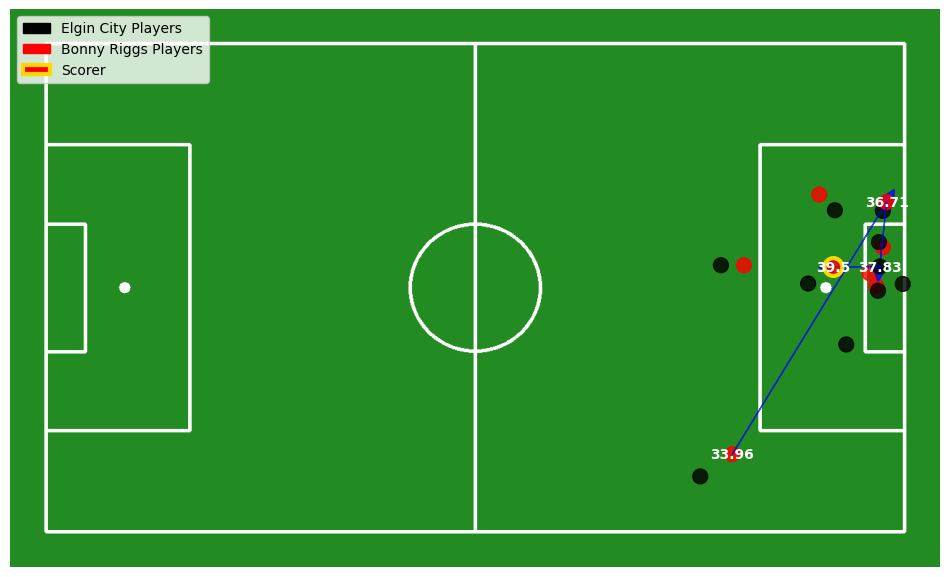

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Draw the pitch
config = SoccerPitchConfigurationNew()
pitch = SoccerPitchDrawer(config)
annotated_frame = pitch.draw_pitch()

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(annotated_frame, extent=[0, 12500, 0, 7500])

df = pd.read_csv('detection_data5_gmm.csv')

frame_956_df = df[(df["Frame"] == 956) & (df["Has Ball"] == False)]

# Annotate players from frame 936
for i, player in frame_956_df.iterrows():
    x, y = player["Pitch X"], player["Pitch Y"]
    team_color = "black" if player["Team ID"] == 1 else "red"
    
    # Draw player as a circle
    player_circle = patches.Circle((x, y), radius=100, color=team_color, alpha=0.8)
    ax.add_patch(player_circle)
    rounded_timestamp = round(player["timestamp"], 2)
    # Add player ID as text
    # ax.text(
    #     x, y, f"{rounded_timestamp}",
    #     color="white", ha="center", va="center", fontsize=10, weight="bold"
    # )
# Filter players who have the ball

df = df[df["Has Ball"] == True]

# Ensure distinct Player IDs by keeping the last occurrence per Player ID
df = df.drop_duplicates(subset=["Player ID"], keep="last")

# Goal timestamp
goal_timestamp = df["timestamp"].max()
# Filter data for the last 4 seconds
filtered_df = df[df["timestamp"] >= goal_timestamp - 6].reset_index(drop=True)

# Annotate players and passes
for i, player in filtered_df.iterrows():
    x, y = player["Pitch X"], player["Pitch Y"]
    team_color = "black" if player["Team ID"] == 1 else "red"
    
    # Draw player as a circle
    player_circle = patches.Circle((x, y), radius=100, color=team_color, alpha=0.8)
    ax.add_patch(player_circle)
    rounded_timestamp = round(player["timestamp"], 2)
    # Add player ID as text
    ax.text(
        x, y, f"{rounded_timestamp}",
        color="white", ha="center", va="center", fontsize=10, weight="bold"
    )
    
    # Draw arrow to the next player if available
    if i < len(filtered_df) - 1:
        next_player = filtered_df.iloc[i + 1]
        next_x, next_y = next_player["Pitch X"], next_player["Pitch Y"]
        ax.arrow(
            x, y, next_x - x, next_y - y,
            head_width=200, head_length=200, fc="blue", ec="blue", alpha=0.7
        )


# Highlight the scorer (last player)
scorer = filtered_df.iloc[-1]
scorer_x, scorer_y = scorer["Pitch X"], scorer["Pitch Y"]
scorer_circle = patches.Circle(
    (scorer_x, scorer_y), radius=120, edgecolor="gold", facecolor="none", lw=3
)
ax.add_patch(scorer_circle)

# Add a legend
legend_elements = [
    patches.Patch(color='black', label='Elgin City Players'),
    patches.Patch(color='red', label='Bonny Riggs Players'),
    patches.Patch(edgecolor='gold', facecolor='red', label='Scorer',lw=3)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
ax.set_xlim(0, 12500)  # Set pitch X limits
ax.set_ylim(0, 7500)   # Set pitch Y limits
ax.invert_yaxis()      # Invert Y-axis to match pitch orientation
plt.axis("off")
plt.show()

In [23]:
filtered_df

,Frame,timestamp,Team ID,Player ID,Has Ball,BBox,Position,PositionAdj,PositionT,Speed (km/h),Distance (m),Team 1 Control(%),Team 2 Control (%),Pitch X,Pitch Y
0,815,33.958333,2,601,True,"[1287.7132568359375, 582.1773071289062, 1357.4...","(1322, 757)","(1322, 757)","[8302.9736328125, 7871.7353515625]",2.565286,2.157429,69.362745,30.637255,9209.313477,6082.753418
1,881,36.708333,2,698,True,"[727.1107177734375, 451.7643127441406, 749.551...","(738, 513)","(738, 513)","[8499.1845703125, 6156.568359375]",NaN,NaN,69.920545,30.079455,11783.515630,2595.516357
2,908,37.833333,1,707,True,"[1149.112060546875, 511.47088623046875, 1169.7...","(1159, 560)","(1159, 560)","[9646.0732421875, 5920.92431640625]",NaN,NaN,70.847085,29.152915,11689.705080,3461.375000
3,948,39.500000,2,735,True,"[781.8814086914062, 468.5706481933594, 839.451...","(810, 590)","(810, 590)","[5349.90771484375, 10402.423828125]",NaN,NaN,70.073762,29.926238,11067.296880,3468.051025


#Training



In [ ]:
# !yolo task=detect mode=train model=yolov5x.pt data={dataset.location}/data.yaml epochs=100 imgsz=640